# PaddlePaddle Yolo with OpenVINO - Object Detection Sample Code

This sample shows how to run the PaddlePaddle Yolo Detection algorithm with OpenVINO natively. This is an experimental release and thus maybe unstable. If you have any issue running any of the code. Please file a bug with us on https://github.com/openvinotoolkit. Thank you.

PPYOLO Model Configuration: 
- https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.1/configs/ppyolo

YOLOV3 Model Configuration:
- https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.1/configs/yolov3

PPYOLO Annotation Data:
- https://github.com/PaddlePaddle/PaddleDetection/blob/release/2.2/docs/tutorials/config_annotation/ppyolo_r50vd_dcn_1x_coco_annotation.md

Author: Raymond Lo, PhD (OpenVINO Edge AI Software Evangelist - Intel)

In [13]:
import os, sys, os.path
import numpy as np
import cv2
from openvino.inference_engine import IENetwork, IECore, ExecutableNetwork
from IPython import display
from PIL import Image, ImageDraw
import urllib, shutil, json
import yaml
from yaml.loader import SafeLoader

## Download and Export Baidu Models - YOLOV3 and PPYOLO

This may take a while. Please ensure the PaddleDetection GitHub is installed in the **openvino-paddlepaddle-demo** directory by following the setup instructions in the README. 

Reference on Baidu Model Exporting:
https://github.com/PaddlePaddle/PaddleDetection/blob/release/2.1/deploy/EXPORT_MODEL.md


In [14]:
#Get the PPYOLO
PADDLE_DET_PATH="../../PaddleDetection"
YML_CONFIG="configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml"
PRETRAINED="ppyolo_r50vd_dcn_1x_coco.pdparams"
OUTPUT_DIR="models"
if(not os.path.isfile("models/ppyolo_r50vd_dcn_1x_coco/model.pdmodel")):
    print("Downloading and Export Model... This may take a while...")
    ! python $PADDLE_DET_PATH/tools/export_model.py -c $PADDLE_DET_PATH/$YML_CONFIG -o use_gpu=false weights=https://paddledet.bj.bcebos.com/models/$PRETRAINED  "TestReader.inputs_def.image_shape=[3,608,608]" --output_dir=$OUTPUT_DIR
else:
    print("Model is already downloaded")
    

Model is already downloaded


In [15]:
#Get the YOLOV3
PADDLE_DET_PATH="../../PaddleDetection"
YML_CONFIG="configs/yolov3/yolov3_darknet53_270e_coco.yml"
PRETRAINED="yolov3_darknet53_270e_coco.pdparams"
OUTPUT_DIR="models"
if(not os.path.isfile("models/yolov3_darknet53_270e_coco/model.pdmodel")):
    print("Downloading and Export Model... This may take a while...")
    ! python $PADDLE_DET_PATH/tools/export_model.py -c $PADDLE_DET_PATH/$YML_CONFIG -o use_gpu=false weights=https://paddledet.bj.bcebos.com/models/$PRETRAINED  "TestReader.inputs_def.image_shape=[3,608,608]" --output_dir=$OUTPUT_DIR
else:
    print("Model is already downloaded")

Model is already downloaded


In [16]:
#Helper functions
def image_preprocess(input_image, size):
    img = cv2.resize(input_image, (size,size))
    img = np.transpose(img, [2,0,1]) / 255
    img = np.expand_dims(img, 0)
    ##NormalizeImage: {mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225], is_scale: True}
    img_mean = np.array([0.485, 0.456,0.406]).reshape((3,1,1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3,1,1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

def draw_box(img, results, label_text, scale_x, scale_y):
    for i in range(len(results)):
        #print(results[i])
        bbox = results[i, 2:]
        label_id = int(results[i, 0])
        score = results[i, 1]
        if(score>0.20):
            xmin, ymin, xmax, ymax = [int(bbox[0]*scale_x), int(bbox[1]*scale_y), 
                                      int(bbox[2]*scale_x), int(bbox[3]*scale_y)]
            cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(0,255,0),3)
            font = cv2.FONT_HERSHEY_SIMPLEX
            label_text = label_list[label_id];
            cv2.rectangle(img, (xmin, ymin), (xmax, ymin-70), (0,255,0), -1)
            cv2.putText(img, "#"+label_text,(xmin,ymin-10), font, 1.2,(255,255,255), 2,cv2.LINE_AA)
            cv2.putText(img, str(score),(xmin,ymin-40), font, 0.8,(255,255,255), 2,cv2.LINE_AA)
    return img

In [17]:
# You can switch between two different models here
#PPYolo
pdmodel_path = "models/ppyolo_r50vd_dcn_1x_coco"
#PPYolo3
#pdmodel_path = "models/yolov3_darknet53_270e_coco"

pdmodel_file = pdmodel_path + "/model.pdmodel"
pdmodel_config = pdmodel_path + "/infer_cfg.yml"
device = 'CPU'

#load the data from config, and setup the parameters
label_list=[]
with open(pdmodel_config) as f:
    data = yaml.load(f, Loader=SafeLoader)
label_list = data['label_list'];

In [18]:
ie = IECore()
net = ie.read_network(pdmodel_file)

net.reshape({'image': [1, 3, 608, 608], 'im_shape': [
            1, 2], 'scale_factor': [1, 2]})

exec_net = ie.load_network(net, device)
assert isinstance(exec_net, ExecutableNetwork)

In [19]:
input_image = cv2.imread("horse.jpg")
test_image = image_preprocess(input_image, 608)
test_im_shape = np.array([[608, 608]]).astype('float32')
test_scale_factor = np.array([[1, 2]]).astype('float32')
#print(test_image.shape)

inputs_dict = {'image': test_image, "im_shape": test_im_shape,
               "scale_factor": test_scale_factor}

output = exec_net.infer(inputs_dict)
result_ie = list(output.values())

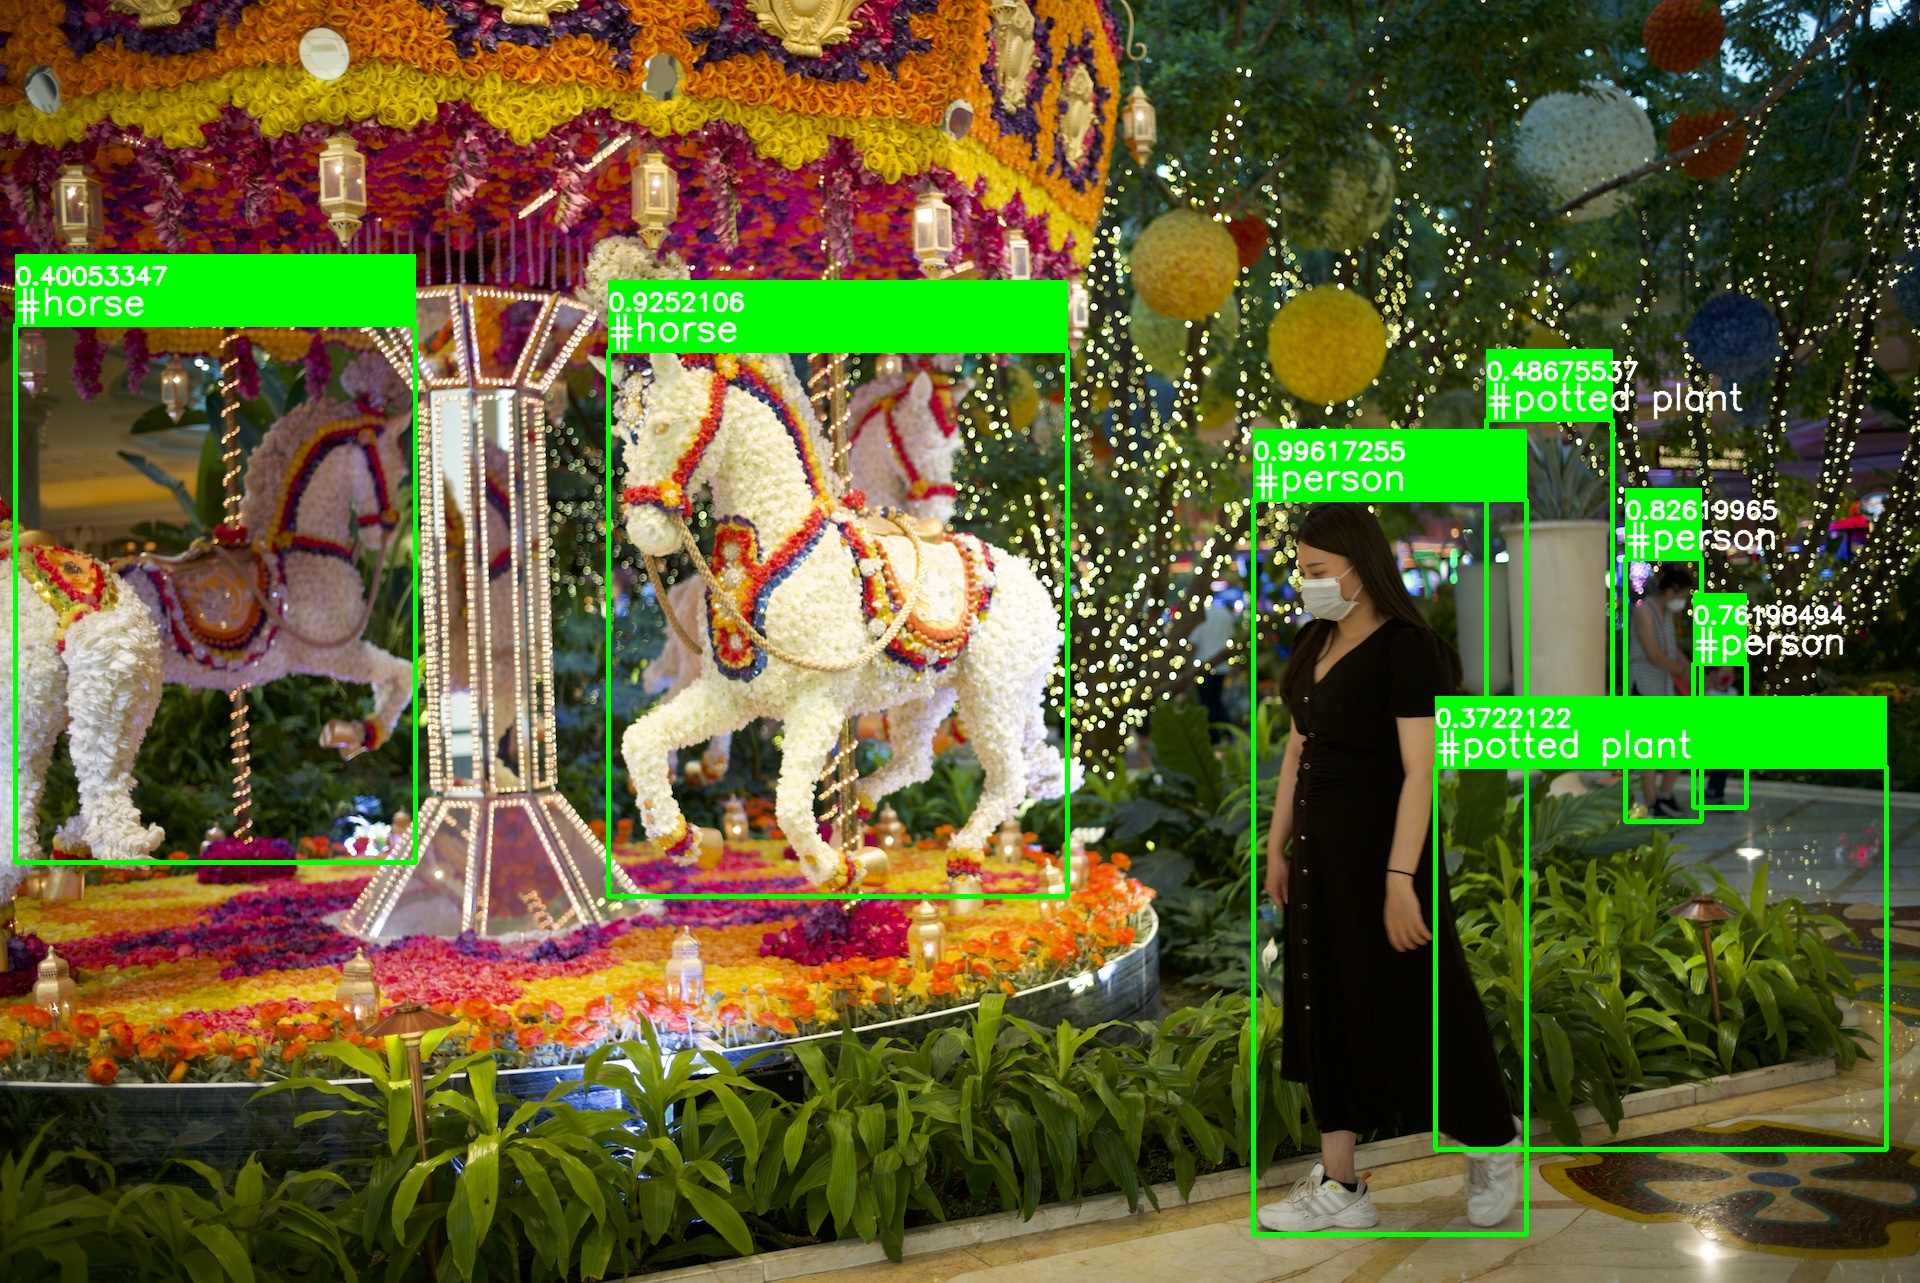

True

In [20]:
result_image = cv2.imread("horse.jpg")
scale_x = result_image.shape[1]/608*2
scale_y = result_image.shape[0]/608
result_image = draw_box(result_image, result_ie[0], label_list, scale_x, scale_y)
_,ret_array = cv2.imencode('.jpg', result_image) 
i = display.Image(data=ret_array)            
display.display(i)

cv2.imwrite("yolo-output.png",result_image) 

In [21]:
def YoloVideo(VideoIndex=0, scale=0.5):
    #PPYolo3
    pdmodel_path = "models/yolov3_darknet53_270e_coco"

    pdmodel_file = pdmodel_path + "/model.pdmodel"
    pdmodel_config = pdmodel_path + "/infer_cfg.yml"
    device = 'CPU'

    #load the data from config, and setup the parameters
    label_list=[]
    with open(pdmodel_config) as f:
        data = yaml.load(f, Loader=SafeLoader)
    label_list = data['label_list'];
    
    ie = IECore()
    net = ie.read_network(pdmodel_file)

    net.reshape({'image': [1, 3, 608, 608], 'im_shape': [
                1, 2], 'scale_factor': [1, 2]})

    exec_net = ie.load_network(net, device)
    assert isinstance(exec_net, ExecutableNetwork)
    
    try:
        cap = cv2.VideoCapture(VideoIndex)
    except:
        print("Cannot Open Device")
        del exec_net
    try:
        ret, frame = cap.read()
        
        while(ret==True):
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            if not ret:
                # Release the Video Device if ret is false
                cap.release()
                # Message to be displayed after releasing the device
                print ("Released Video Resource")
                break
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            half_frame = cv2.resize(frame, (0, 0), fx = scale, fy = scale)
             
            #Processing the Frame
            test_image = image_preprocess(half_frame, 608)
            test_im_shape = np.array([[608, 608]]).astype('float32')
            test_scale_factor = np.array([[1, 2]]).astype('float32')
            #print(test_image.shape)
            inputs_dict = {'image': test_image, "im_shape": test_im_shape,
                           "scale_factor": test_scale_factor}

            output = exec_net.infer(inputs_dict)
            result_ie = list(output.values())
            
            result_image = half_frame.copy()
            #result_image = cv2.resize(result_image, (int(608*1.0),int(608*1.0)))
            scale_x = result_image.shape[1]/608*2
            scale_y = result_image.shape[0]/608
            
            result_image = draw_box(result_image, result_ie[0], label_list, scale_x, scale_y)
            
            #convert to jpg for performance results
            _,ret_array = cv2.imencode('.jpg', result_image) 
            i = display.Image(data=ret_array)            
            
            display.display(i)
            display.clear_output(wait=True)
    except KeyboardInterrupt:
        # Release the Video Device
        cap.release()
        # Message to be displayed after releasing the device
        print("Released Video Resource from KeyboardInterrupt")
        del exec_net
    pass

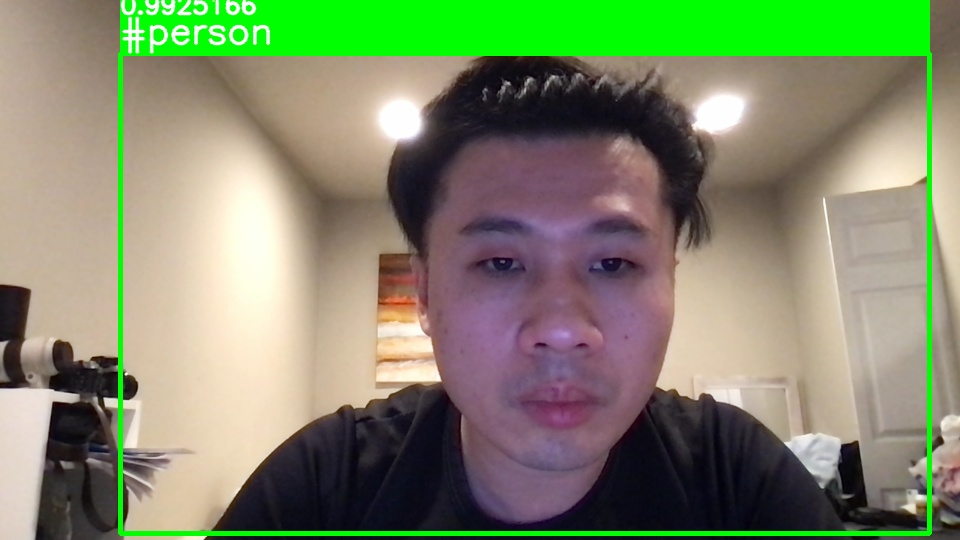

In [ ]:
YoloVideo(1, 0.75)